# SHAO 2018 SKA Summer School
## Simulating the response of an Interferometer
### J. Line

The following code is designed to help you consolidate your understanding of the fundamentals of interferometry, introduce you to the most basic forms of interferometric data and imaging, and demonstrate the computational challenges of simulating the response of an interferometer. We'll do this by simulating an observation using the MWA phase I layout.

At the core of the simulation, we need to evaluate the interferometric equation
\begin{equation}
V(u,v,w) = \iint I(l,m) \exp[-2\pi i (ul + vm + w(n-1))]\,\dfrac{dl dm}{n}
\end{equation}

for all the baselines in our interferometer $(u,v,w)$, across as much of the sky $l,m,n$ as possible.

We can split this up across the sky as a finite number of point sources (delta functions) like so
\begin{equation}
V(u,v,w) = \sum^n_i I(l_i,m_i) \exp[-2\pi i (u_il_i + v_im_i + w_i(n_i-1))],
\end{equation}

which is an efficient way of splitting up the problem computationally.

Our first step will be to load the relevant modules and functions needed to run this notebook:

In [1]:
##Modules we will use in the course of this lecture
from __future__ import division
from __future__ import print_function
from astropy.io import fits
from ephem import Observer
from numpy import *
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from interfero_functions import *

##Useful constants defined below
##Convert degrees/rads
D2R = pi/180.0
R2D = 180.0/pi
##Speed of light m/s
VELC = 299792458.0
##Latitude of the MWA
MWA_LAT = -26.7033194444
##Always set the kernel size to an odd value
##Makes all ranges set to zero at central values
KERNEL_SIZE = 31
##Rotational velocity of the Earth rad / sex
W_E = 7.292115e-5
##Sidereal seconds per solar seconds - ie if 1s passes on
##the clock, sky has moved by 1.00274 secs of angle
SOLAR2SIDEREAL = 1.00274

The first step in simulating our observation is to setup the layout of our interferometer. To do that, we need to know how the receiving elements are arranged, and frame them in a convenient coordinate system. We'll start by reading in the tile positions for MWA phase 1, which are stored in the commonly used `east, north, height` system.


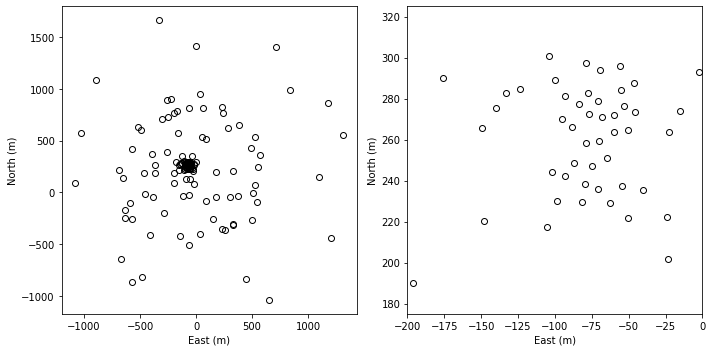

In [2]:
%matplotlib inline

##Text file containing e,n,h coords
array_layout = 'antenna_locations_MWA_phase1.txt'
anntenna_locs = loadtxt(array_layout)
east, north, height = anntenna_locs[:,0],anntenna_locs[:,1],anntenna_locs[:,2]

##Make a plot and have a look
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)
ax1.plot(east,north,'ko',mfc='none')
ax1.set_xlabel('East (m)')
ax1.set_ylabel('North (m)')

ax2 = fig.add_subplot(122)
ax2.plot(east,north,'ko',mfc='none')
ax2.set_xlabel('East (m)')
ax2.set_ylabel('North (m)')
ax2.set_xlim(-200,0)
ax2.set_ylim(175,325)
plt.tight_layout()

The most convenient coordinate system to frame our tile locations in is local $X,Y,Z$ coordinates. This coordinate system (shown in the left below) is defined by hour angle $H$ and declination $\delta$, and so is fixed for the observer. This make it ideal to calculate our $u,v,w$ coordinate system (an example of which is shown on the right).
<table><tr><td><img src='XYZ.png'></td><td><img src='uvw.jpg'></td></tr></table>

In [3]:
##Do conversion from enh into XYZ
X,Y,Z = enh2xyz(east, north, height, MWA_LAT*D2R)

In the lecture we will look at the video `coords.mp4` here.

By taking the distance between two tiles in the $X,Y,Z$ system, and scaling by the wavelength we want to observe at, we obtain $X_\lambda,Y_\lambda,Z_\lambda$ for each baseline. We can then use them to calculate $u,v,w$ using:

\begin{equation}
\begin{pmatrix}
u \\
v \\
w
\end{pmatrix} = 
\begin{pmatrix}
\sin(H_0) & \cos(H_0) & 0 \\
-\sin(\delta_0)\cos(H_0) & \sin(\delta_0)\sin(H_0) & \cos(\delta_0) \\
\cos(\delta_0)\cos(H_0) & -\cos(\delta_0)\sin(H_0) & \sin(\delta_0) 
\end{pmatrix}
\begin{pmatrix}
X_\lambda \\
Y_\lambda \\
Z_\lambda
\end{pmatrix},
\end{equation}

where $H_0,\delta_0$ describe the hour angle and declination of the phase centre.

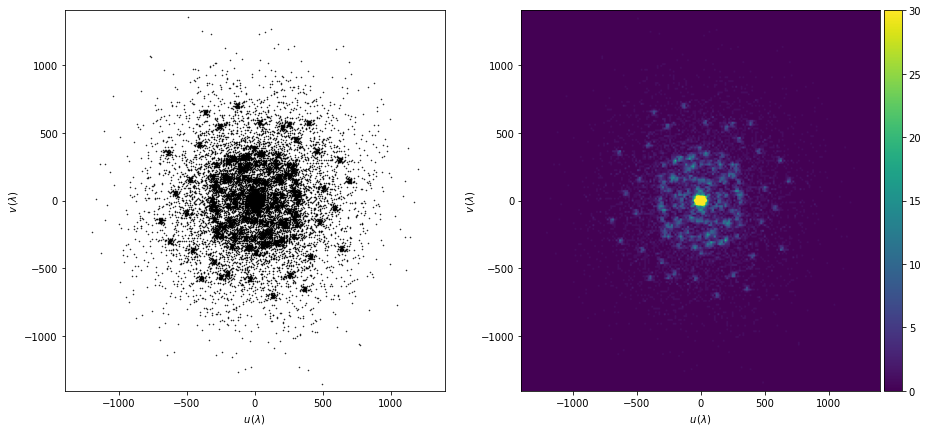

In [4]:
x_lengths = []
y_lengths = []
z_lengths = []

for tile1 in range(0,len(X)):
    for tile2 in range(tile1+1,len(X)):
        x_len = X[tile2] - X[tile1]
        y_len = Y[tile2] - Y[tile1]
        z_len = Z[tile2] - Z[tile1]
        
        x_lengths.append(x_len)
        y_lengths.append(y_len)
        z_lengths.append(z_len)

frequency = 150e+6
wavelength = VELC / frequency

x_lamb = array(x_lengths) / wavelength
y_lamb = array(y_lengths) / wavelength
z_lamb = array(z_lengths) / wavelength

u_zen,v_zen,w_zen = get_uvw(x_lamb,y_lamb,z_lamb,MWA_LAT*D2R,0.0)

max_coord = 1400

##Make a plot and have a look
fig = plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(121)
ax1.plot(u_zen,v_zen,'k.',mfc='none',ms=1)
ax1.plot(-u_zen,-v_zen,'k.',mfc='none',ms=1)
ax1.set_xlabel('$u\,(\lambda)$')
ax1.set_ylabel('$v\,(\lambda)$')
ax1.set_xlim(-max_coord,max_coord)
ax1.set_ylim(-max_coord,max_coord)


nside = 201

u_range = linspace(-max_coord,max_coord,nside)
v_range = linspace(-max_coord,max_coord,nside)

gridded_uv = zeros((len(v_range),len(u_range)),dtype=complex)

gridded_uv = grid(container=gridded_uv,u_coords=u_zen, v_coords=v_zen, u_range=u_range,
                  v_range=v_range,complexes=ones(len(u_zen),dtype=complex),kernel=None)
gridded_uv = grid(container=gridded_uv,u_coords=-u_zen, v_coords=-v_zen, u_range=u_range, 
                  v_range=v_range,complexes=ones(len(u_zen),dtype=complex),kernel=None)

ax2 = fig.add_subplot(122)
im = ax2.imshow(gridded_uv.real,origin='lower',extent=[-max_coord,max_coord,-max_coord,max_coord],aspect='auto',vmax=30)

divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(im, cax = cax)
ax2.set_xlabel('$u\,(\lambda)$')
ax2.set_ylabel('$v\,(\lambda)$')


fig.savefig('uvw_coverage.png',bbox_inches='tight')


In the lecture we'll look at the two videos `rotation_synthesis.mp4` and `frequency_synthesis.mp4` now.

Now that we know how to calculate $u,v,w$, we need to calcualte $l,m$ to evaluate the interferometric equation. Let us consider a point source with right ascension and declination $RA,\delta$. We chose a particular phase centre, $RA_0,\delta_0$, which defines the origin of our $l,m$ and $u,v,w$ coordinate systems:

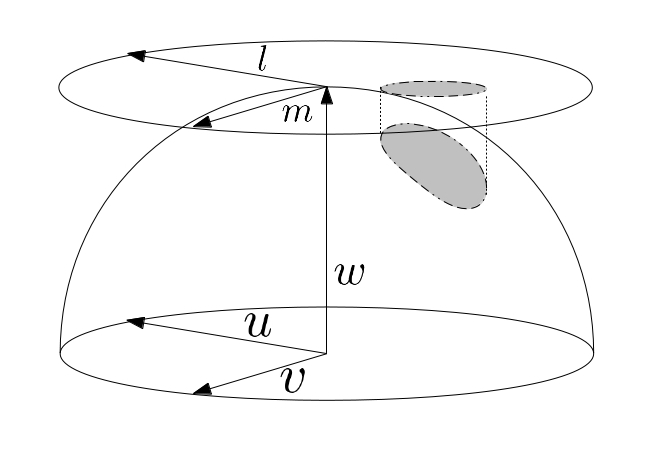

and then the calculation of $l,m$ is simply a trigonometric function invloving $RA,\delta,RA_0,\delta_0$. We saw earlier that we calculate $u,v,w$ using $H_0$, so to do both calculations, we need to know the local sidereal time ($LST$) as well, as $H_0 = LST - RA_0$. We can do that using the `ephem` object `Observer`

In [5]:
MRO = Observer()
MRO.lat, MRO.long, MRO.elevation = '-26:42:11.95', '116:40:14.93', 0
date = '2018/08/06 18:00:00'
lst = float(MRO.sidereal_time())
##Initial_lst is in radians

##Set the initial sky position of our source to zenith
ra, dec = lst, MWA_LAT
ra0,dec0 = ra,dec
l,m,n = get_lm(ra=ra,ra0=ra0,dec=dec,dec0=dec0)

##Calculate hour angle of phase centre
h0 = lst - ra0

##x_lamb,y_lamb,z_lamb are set to 150MHz
u,v,w = get_uvw(x_lamb,y_lamb,z_lamb,dec0,h0)

Ok! Now we have nearly everything we need, apart from the flux density of the source. Let's make it a 2$\,$Jy, and calculate the visibilities for all the baselines

In [6]:
flux_density = 2.0
this_vis = flux_density * exp(-2j*pi*(u*l + v*m + w*(n-1)))

print(this_vis)

[2.+0.j 2.+0.j 2.+0.j ... 2.+0.j 2.+0.j 2.+0.j]


They are all 2 with no imaginary component as we are directly phase tracking this patch of sky; this makes the source completely coherent. What happens if we switch off phase tracking?

In [7]:
this_vis = flux_density * exp(-2j*pi*(u*l + v*m + w*n))

print(this_vis)

[ 1.56674537-1.24310456j  1.97441719+0.31886794j -1.30069163-1.51927656j
 ...  1.03677012-1.71029463j -1.9263822 +0.5376352j
 -1.45836506-1.36863851j]


We get a variety of visibilities, as we are no longer accounting for the different path lengths across each baseline due to the position of the source in the sky. For the remainder of this notebook we will continue with the phase tracking case. Let's try moving our point source away from the phase centre, and investigate the visibility of a single baseline over time:

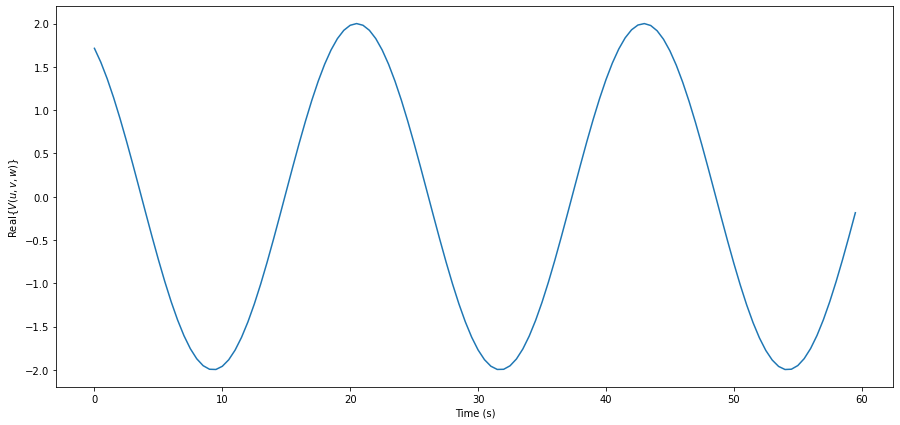

In [8]:
ra, dec = ra0+5, dec0+5.
l,m,n = get_lm(ra=ra,ra0=ra0,dec=dec,dec0=dec0)

time_range = arange(0.,60.,0.5)

##there are 15 degrees in 1 hour of angle
##there are 3600 arcsecs in 1 hour of angle
##Sidereal seconds per solar seconds - ie if 1s passes on
##the clock, sky has moved by 1.00274 secs of angle

angle_range_deg = time_range*SOLAR2SIDEREAL*(15.0/3600.0)
angle_range_rad = angle_range_deg*D2R

##The lst changes with time
lst_range = lst + angle_range_rad


baseline = 7383
visibilities = []
for lst_now in lst_range:
    h0 = lst_now - ra0
    u,v,w = get_uvw(x_lamb[baseline],y_lamb[baseline],z_lamb[baseline],dec0,h0)
    this_vis = flux_density * exp(-2j*pi*(u*l + v*m + w*(n-1)))
    
    visibilities.append(this_vis)
    
visibilities = array(visibilities)


fig = plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(111)
ax1.plot(time_range,visibilities.real)
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Real{$V(u,v,w)$}')

fig.savefig('fringe_frequency.png')

So now we can see the visibility of our source changing as the path difference across the baseline changes, due to a combination of the source moving across the sky, and the phase that we insert to phase track $RA_0,\delta_0$ changing. The frequency of this is know as the *fringe frequency*.

When considering a small enough sky area, the following holds true:

\begin{equation}
I_D(l,m) = \mathrm{FFT} \lbrace V(u,v) \rbrace
\end{equation}

where $I_D$ is the *dirty image*, and $\mathrm{FFT}$ stands for fast fourier transform. So, to inspect our data in image space, we need to first grid the data onto a regular grid, which we can then $\mathrm{FFT}$ to obtain an image. Let's go back to our point source at zenith example, grid the data, take the , and inspect the outcome

Max flux point in image is 2.0
Extent in l is 4.1 degrees


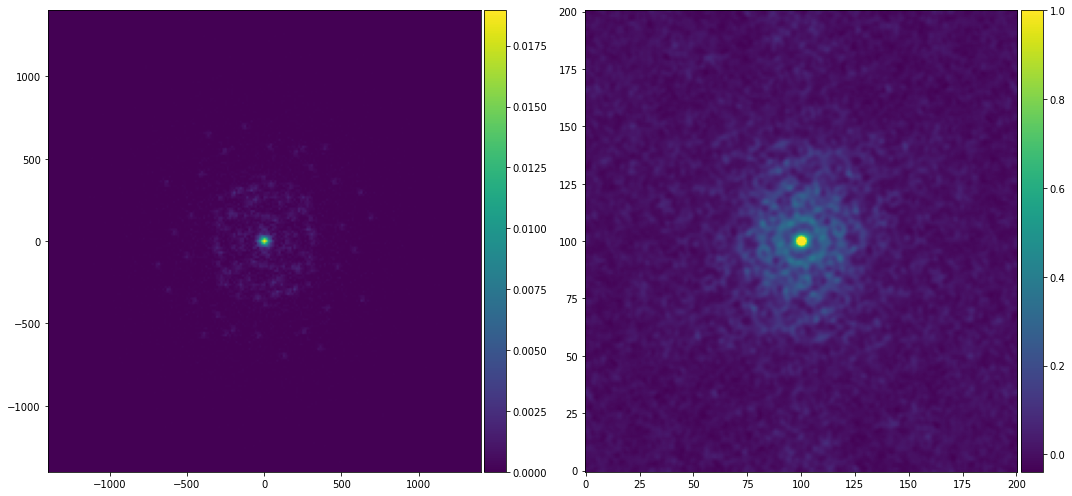

In [9]:
##Set the initial sky position of our source to zenith
ra, dec = lst, MWA_LAT*D2R
ra0,dec0 = ra,dec
l,m,n = get_lm(ra=ra,ra0=ra0,dec=dec,dec0=dec0)

##Calculate hour angle of phase centre
h0 = lst - ra0

##x_lamb,y_lamb,z_lamb are set to 150MHz
u,v,w = get_uvw(x_lamb,y_lamb,z_lamb,dec0,h0)

visibilities = flux_density * exp(-2j*pi*(u*l + v*m + w*(n-1)))

nside = 201
max_u = 1401
max_v = 1401

u_range = linspace(-max_u,max_u,nside)
v_range = linspace(-max_v,max_v,nside)

gridded_uv = zeros((len(v_range),len(u_range)),dtype=complex)

gridded_uv = grid(container=gridded_uv,u_coords=u, v_coords=v, u_range=u_range,
                  v_range=v_range,complexes=visibilities,kernel=None)

##Visibilities have property that the conjugate can also be gridded
##at the negative of the u,v coords - makes images better!
gridded_uv = grid(container=gridded_uv,u_coords=-u, v_coords=-v, u_range=u_range, 
                  v_range=v_range,complexes=conjugate(visibilities),kernel=None)

##Need to average the gridded visibilities by the number of visibilities
gridded_uv /= 2*8128.0

gridded_shift = fft.ifftshift(gridded_uv)
img_array = fft.fft2(gridded_shift)
img_array_shift = fft.fftshift(img_array)

##Make a plot and have a look
fig = plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

im1 = ax1.imshow(gridded_uv.real,origin='lower',extent=[-max_u,max_u,-max_v,max_v],aspect='auto')
im2 = ax2.imshow(img_array_shift.real,origin='lower',aspect='auto',vmax=1.0)

def do_cbar(im,ax):

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(im, cax = cax)


do_cbar(im1,ax1)
do_cbar(im2,ax2)

plt.tight_layout()

print('Max flux point in image is %.1f' %img_array_shift.real.max())

u_reso = u_range[1] - u_range[0]
l_extent = 1 / u_reso
l_angle = arcsin(l_extent)*R2D

print('Extent in l is %.1f degrees' %l_angle)
plt.show()
fig.savefig('synthesized_PSF.png',bbox_inches='tight')

As visibilities are additive, all we need to do to simulate more sky is to calculate the visibilities at other $l,m,n$ locations and sum them:

Max flux point in image is 2.0
Extent in l is 7.7 degrees


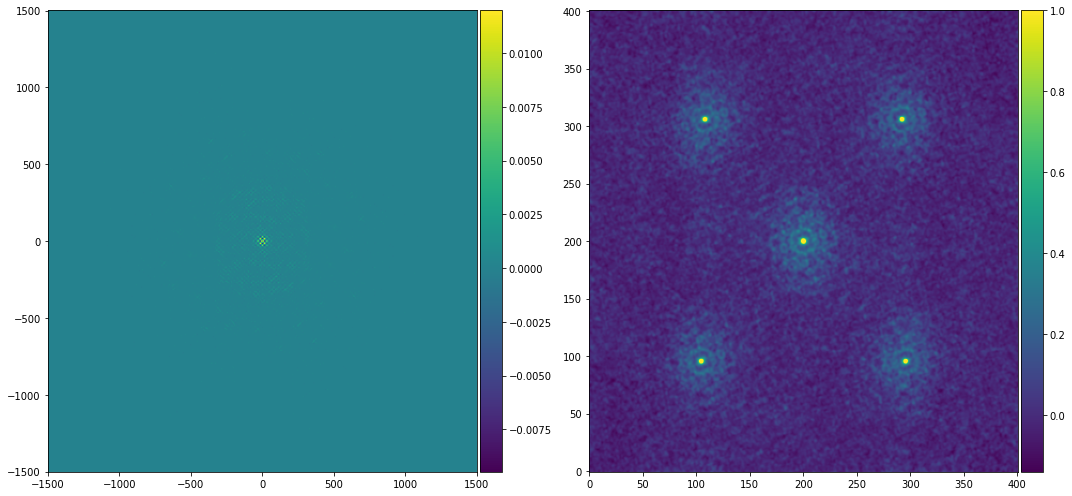

In [10]:
##Set the initial sky position of our source to zenith
ra, dec = lst, MWA_LAT*D2R
ra0,dec0 = lst, MWA_LAT*D2R
l,m,n = get_lm(ra=ra,ra0=ra0,dec=dec,dec0=dec0)


##Calculate hour angle of phase centre
h0 = lst - ra0

##x_lamb,y_lamb,z_lamb are set to 150MHz
u,v,w = get_uvw(x_lamb,y_lamb,z_lamb,dec0,h0)

visibilities = flux_density * exp(-2j*pi*(u*l + v*m + w*(n-1)))

##Add in 4 point sources surrounding our zenith source
ras = [lst-2*D2R,lst+2*D2R,lst-2*D2R,lst+2*D2R]
decs = [(MWA_LAT+2)*D2R,(MWA_LAT+2)*D2R,(MWA_LAT-2)*D2R,(MWA_LAT-2)*D2R]

for ra,dec in zip(ras,decs):
    l,m,n = get_lm(ra=ra,ra0=ra0,dec=dec,dec0=dec0)
    visibilities += flux_density * exp(-2j*pi*(u*l + v*m + w*(n-1)))

nside = 401
max_u = 1501
max_v = 1501

u_range = linspace(-max_u,max_u,nside)
v_range = linspace(-max_v,max_v,nside)

gridded_uv = zeros((len(v_range),len(u_range)),dtype=complex)

gridded_uv = grid(container=gridded_uv,u_coords=u, v_coords=v, u_range=u_range,
                  v_range=v_range,complexes=visibilities,kernel=None)
gridded_uv = grid(container=gridded_uv,u_coords=-u, v_coords=-v, u_range=u_range, 
                  v_range=v_range,complexes=conjugate(visibilities),kernel=None)

##Need to average the gridded visibilities by the number of visibilities
gridded_uv /= 2*8128.0

gridded_shift = fft.ifftshift(gridded_uv)
img_array = fft.fft2(gridded_shift)
img_array_shift = fft.fftshift(img_array)

##Make a plot and have a look
fig = plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

im1 = ax1.imshow(gridded_uv.real,origin='lower',extent=[-max_u,max_u,-max_v,max_v],aspect='auto')
im2 = ax2.imshow(img_array_shift.real,origin='lower',aspect='auto',vmax=1.0)

def do_cbar(im,ax):

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(im, cax = cax)


do_cbar(im1,ax1)
do_cbar(im2,ax2)

plt.tight_layout()

print('Max flux point in image is %.1f' %img_array_shift.real.max())

u_reso = u_range[1] - u_range[0]
l_extent = 1 / u_reso
l_angle = arcsin(l_extent)*R2D

print('Extent in l is %.1f degrees' %l_angle)
plt.show()
fig.savefig('5_source_sky.png',bbox_inches='tight')

The MWA has recently been upgraded to have a total of 256 tiles, however we still only have enough receiver boxes to attach 128 tiles to the correlator. This has led to two different configurations, known as the 'compact' and 'extended' configurations. Let's see what that does to the synthesized PSF

Max flux point in image is 2.0
Extent in l is 4.1 degrees


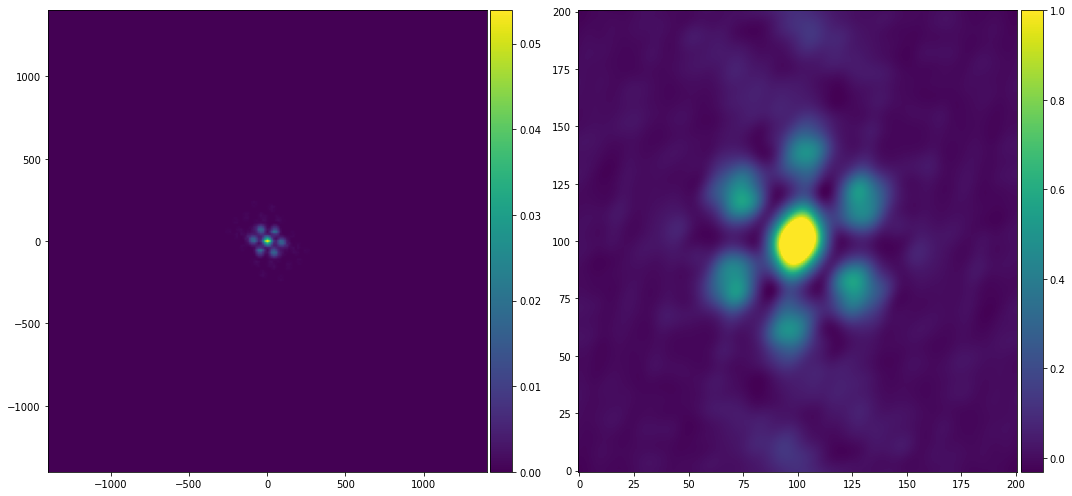

In [11]:
##Text file containing e,n,h coords
array_layout = 'HexMeasured_phaseIIEOR.csv'
anntenna_locs = loadtxt(array_layout,usecols=(1,2,3))
east, north, height = anntenna_locs[:,0],anntenna_locs[:,1],anntenna_locs[:,2]
##Do conversion from enh into XYZ
X,Y,Z = enh2xyz(east, north, height, MWA_LAT*D2R)

x_lengths = []
y_lengths = []
z_lengths = []

for tile1 in range(0,len(X)):
    for tile2 in range(tile1+1,len(X)):
        x_len = X[tile2] - X[tile1]
        y_len = Y[tile2] - Y[tile1]
        z_len = Z[tile2] - Z[tile1]
        
        x_lengths.append(x_len)
        y_lengths.append(y_len)
        z_lengths.append(z_len)

frequency = 150e+6
wavelength = VELC / frequency

x_lamb = array(x_lengths) / wavelength
y_lamb = array(y_lengths) / wavelength
z_lamb = array(z_lengths) / wavelength



##Set the initial sky position of our source to zenith
lst = 0.0
ra, dec = lst, MWA_LAT*D2R
ra0,dec0 = ra,dec
l,m,n = get_lm(ra=ra,ra0=ra0,dec=dec,dec0=dec0)

##Calculate hour angle of phase centre
h0 = lst - ra0

##x_lamb,y_lamb,z_lamb are set to 150MHz
u,v,w = get_uvw(x_lamb,y_lamb,z_lamb,dec0,h0)

visibilities = 2.0 * exp(-2j*pi*(u*l + v*m + w*(n-1)))

nside = 201
max_u = 1401
max_v = 1401

u_range = linspace(-max_u,max_u,nside)
v_range = linspace(-max_v,max_v,nside)

gridded_uv = zeros((len(v_range),len(u_range)),dtype=complex)

gridded_uv = grid(container=gridded_uv,u_coords=u, v_coords=v, u_range=u_range,
                  v_range=v_range,complexes=visibilities,kernel=None)
gridded_uv = grid(container=gridded_uv,u_coords=-u, v_coords=-v, u_range=u_range, 
                  v_range=v_range,complexes=conjugate(visibilities),kernel=None)

##Need to average the gridded visibilities by the number of visibilities
gridded_uv /= 2*8128.0

gridded_shift = fft.ifftshift(gridded_uv)
img_array = fft.fft2(gridded_shift)
img_array_shift = fft.fftshift(img_array)

##Make a plot and have a look
fig = plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

im1 = ax1.imshow(gridded_uv.real,origin='lower',extent=[-max_u,max_u,-max_v,max_v],aspect='auto')
im2 = ax2.imshow(img_array_shift.real,origin='lower',aspect='auto',vmax=1.0)

def do_cbar(im,ax):

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(im, cax = cax)


do_cbar(im1,ax1)
do_cbar(im2,ax2)

plt.tight_layout()

print('Max flux point in image is %.1f' %img_array_shift.real.max())

u_reso = u_range[1] - u_range[0]
l_extent = 1 / u_reso
l_angle = arcsin(l_extent)*R2D

print('Extent in l is %.1f degrees' %l_angle)
plt.show()
fig.savefig('synthesized_PSF_compact.png',bbox_inches='tight')

Max flux point in image is 2.0
Extent in l is 3.8 degrees


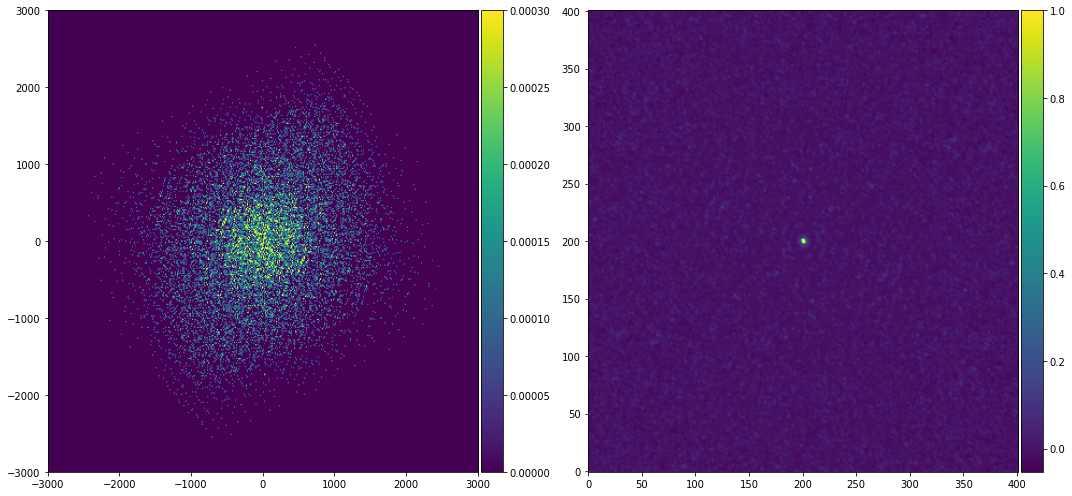

In [12]:
##Text file containing e,n,h coords
array_layout = 'Phase2_LB_Surveyed_Coordinates.csv'
#anntenna_locs = loadtxt(array_layout,usecols=(2,3,4))

east = []
north = []
height = []

lines = [line for line in open(array_layout,'r').read().split('\n') if line != '']
for line in lines:
    a,b,c,h,n,e = line.split(',')
    east.append(float(e))
    north.append(float(n))
    height.append(float(h))

#height, east, north = anntenna_locs[:,0],anntenna_locs[:,1],anntenna_locs[:,2]
##Do conversion from enh into XYZ
X,Y,Z = enh2xyz(array(east), array(north), array(height), MWA_LAT*D2R)

x_lengths = []
y_lengths = []
z_lengths = []

for tile1 in range(0,len(X)):
    for tile2 in range(tile1+1,len(X)):
        x_len = X[tile2] - X[tile1]
        y_len = Y[tile2] - Y[tile1]
        z_len = Z[tile2] - Z[tile1]
        
        x_lengths.append(x_len)
        y_lengths.append(y_len)
        z_lengths.append(z_len)

frequency = 150e+6
wavelength = VELC / frequency

x_lamb = array(x_lengths) / wavelength
y_lamb = array(y_lengths) / wavelength
z_lamb = array(z_lengths) / wavelength



##Set the initial sky position of our source to zenith
lst = 0.0
ra, dec = lst, MWA_LAT*D2R
ra0,dec0 = ra,dec
l,m,n = get_lm(ra=ra,ra0=ra0,dec=dec,dec0=dec0)

##Calculate hour angle of phase centre
h0 = lst - ra0

##x_lamb,y_lamb,z_lamb are set to 150MHz
u,v,w = get_uvw(x_lamb,y_lamb,z_lamb,dec0,h0)

visibilities = 2.0 * exp(-2j*pi*(u*l + v*m + w*(n-1)))

nside = 401
max_u = 3001
max_v = 3001

u_range = linspace(-max_u,max_u,nside)
v_range = linspace(-max_v,max_v,nside)

gridded_uv = zeros((len(v_range),len(u_range)),dtype=complex)

gridded_uv = grid(container=gridded_uv,u_coords=u, v_coords=v, u_range=u_range,
                  v_range=v_range,complexes=visibilities,kernel=None)
gridded_uv = grid(container=gridded_uv,u_coords=-u, v_coords=-v, u_range=u_range, 
                  v_range=v_range,complexes=conjugate(visibilities),kernel=None)

##Need to average the gridded visibilities by the number of visibilities
gridded_uv /= 2*8128.0

gridded_shift = fft.ifftshift(gridded_uv)
img_array = fft.fft2(gridded_shift)
img_array_shift = fft.fftshift(img_array)

##Make a plot and have a look
fig = plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

im1 = ax1.imshow(gridded_uv.real,origin='lower',extent=[-max_u,max_u,-max_v,max_v],aspect='auto',vmax=0.0003)
im2 = ax2.imshow(img_array_shift.real,origin='lower',aspect='auto',vmax=1.0)

def do_cbar(im,ax):

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(im, cax = cax)


do_cbar(im1,ax1)
do_cbar(im2,ax2)

plt.tight_layout()

print('Max flux point in image is %.1f' %img_array_shift.real.max())

u_reso = u_range[1] - u_range[0]
l_extent = 1 / u_reso
l_angle = arcsin(l_extent)*R2D

print('Extent in l is %.1f degrees' %l_angle)
plt.show()
fig.savefig('synthesized_PSF_extended.png',bbox_inches='tight')